# Глубокое обучение

# Лекция 6: Продвинутые модели глубокого машинного зрения

__Авторы__: 
* Сергей Вячеславович Макрушин, e-mail: s-makrushin@yandex.ru
* Леонид Алексеев Владимирович

Финансовый универсиет, 2023 г. 

При подготовке лекции использованы материалы:

* ...

* V 0.1 15.11.2023 


In [1]:
# загружаем стиль для оформления презентации
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen("file:./lec_v2.css")
HTML(html.read().decode('utf-8'))

## Разделы: <a class="anchor" id="разделы"></a>

* [Сверточные сети](#сс)
           
-

* [к оглавлению](#разделы)



https://colab.research.google.com/drive/1AghjX_mmTDirPwPWdSuepSq7sTLG1uhp?usp=sharing#scrollTo=qPKry0D1y2gk

In [9]:
import math
import numpy as np
import tqdm.notebook
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

# import lightning as L
# L.seed_everything(0)

from transformers import AutoImageProcessor, ResNetForImageClassification
from transformers import AutoFeatureExtractor, VanForImageClassification
from datasets import load_dataset
import evaluate

ModuleNotFoundError: No module named 'transformers'

## Постоновки задач

__Типы задач машинного зрения решаемые с помощью глубоких моделей__

* __Классификация изображений__: определяется к какому классу или категории относится изображение (например, определение видов животных, классификация цифр, определение объектов на фотографии). Это одна из наиболее распространенных задач.

* __Семантическая сегментация__ - разделение изображения на сегменты и присвоение каждому сегменту метки класса. Это позволяет понимать, какие части изображения принадлежат к различным объектам (например, сегментация дорог, неба, автомобилей на фотографии).

* __Локализация объектов__ - поиск и определение позиции объектов на изображении с выделением их ограничивающих рамок без привязки к конкретным классам (например, поиск и выделение всех лиц на групповой фотографии).

* __Обнаружение объектов__ - задача выявления и локализации объектов на изображении, размещение ограничивающих рамок вокруг этих объектов и присвоение им меток классов (например, детектирование автомобилей на дороге, лиц на фотографиях).

* __Повышение качества изображений и суперразрешение (superresolution)__ - уменьшения шума и улучшение качества изображений, повышение разрешения изображений.

---

* __Генерация контента__ - создание новых изображений, основанных на обучении на больших наборах данных, что может быть полезно в задачах синтеза изображений или стилизаций.

* __Распознавание действий и сцен__ - определение активностей, сцен или последовательностей событий на основе анализа видеоданных.

__Ограничивающие рамки__

<center>     
    <img src="./img/bb1.png" alt="Изображения двухмерные" style="width: 400px;"/>
    <strong>Расстановка bounding box (ограничвиающих рамок)</strong>
</center>

<center>     
    <img src="./img/bb2.png" alt="Изображения двухмерные" style="width: 400px;"/>
    <strong>Расстановка 3D bounding box (трехмерных ограничвиающих рамок)</strong>
</center>

__Bounding box (ограничительная рамка)__ в задачах машинного зрения - это прямоугольник или параллелепипед, который описывает положение и размер объекта на изображении или в видео. Он задается координатами (обычно левый верхний угол и правый нижний угол) и может быть использован для выделения, обозначения или ограничения области, содержащей интересующий объект. Эта техника широко используется в обнаружении и распознавании объектов, классификации изображений и других задачах компьютерного зрения для точного определения положения объектов на изображениях.

__Виды задач сегментации изображения__

<center>     
    <img src="./img/seg_types.png" alt="Изображения двухмерные" style="width: 550px;"/>
    <strong>Типы сегментации</strong>
</center>

__Семантическая сегментация (Semantic Segmentation)__: этот вид сегментации направлен на присвоение каждому пикселю изображения метки, отражающей его принадлежность к определенному классу или категории объектов. Например, на изображении сцены собаки, кошки и деревья каждый пиксель будет помечен как "собака", "кошка" или "дерево".
* Применение: Семантическая сегментация широко используется в автоматическом восприятии среды для самоуправляемых автомобилей, сегментации медицинских изображений и в различных задачах компьютерного зрения.

__Сегментация экземпляров (Instance Segmentation)__: этот тип сегментации не только определяет категорию объекта на изображении, но и __различает отдельные экземпляры объектов__, присваивая каждому уникальный идентификатор.
* Например, если на изображении присутствуют две собаки, то каждая из них будет помечена отдельно, даже если они относятся к одному классу.
* Применение: Инстансная сегментация полезна в областях, требующих точной локализации и различения между объектами, таких как трекинг объектов в видео, обнаружение людей на изображениях многолюдных сцен, а также в робототехнике и медицинском анализе.

__Паноптическая сегментация (Panoptic Segmentation)__ : этот вид сегментации комбинирует особенности семантической и сегментации экземпляров. Он стремится к __полному покрытию изображения метками__ для всех пикселей, независимо от того, являются ли они частью объекта или фона, и при этом различает отдельные экземпляры объектов. В паноптической сегментации различают:
* __"Thing" (вещь)__ - сегменты изображения, которые представляют объекты, имеющие четкую ограниченную форму и четко выделяемые границы, например, люди, автомобили, животные и другие конкретные объекты.
* __"Stuff" (вещество)__ - сегменты, представляющие более абстрактные или неструктурированные области на изображении, такие как небо, дорога, трава, вода и другие фоновые или окружающие элементы. Эти области обычно не имеют четких границ или форм и чаще представляют собой большие участки изображения.
* Паноптическая сегментация стремится к объединению "thing" и "stuff", предоставляя __полную семантическую сегментацию всего изображения__, которая включает в себя как объекты "thing", так и контекстуальные области "stuff". 
* Применение: Паноптическая сегментация полезна в задачах, где важно не только понимание содержимого изображения, но и различение между объектами и фоном для полного восприятия сцены. Она находит применение в автоматическом анализе видео, управлении трафиком, а также в робототехнике для принятия решений на основе окружающей среды.

## Популярные архитектуры

__Архитектура VGG__

__VGG16__ — модель сверточной нейронной сети, предложенная в 2014 г. K. Simonyan и A. Zisserman из Оксфордского университета
* Модель достигает __точности 92.7% — топ-5__, при тестировании на ImageNet в задаче распознавания объектов на изображении.
* VGG16 — одна из самых знаменитых моделей, отправленных на соревнование ILSVRC-2014. 
* Она является __улучшенной версией AlexNet__, в которой __заменены большие фильтры__ (размера 11 и 5 в первом и втором сверточном слое, соответственно) __на несколько фильтров размера 3х3__, следующих один за другим. 
* Использовать предобученную VGG16 в PyTorch можно используя этот вызов: https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
* Модель предложена в статье  “Very Deep Convolutional Networks for Large-Scale Image Recognition” см. https://arxiv.org/pdf/1409.1556.pdf

<center>     
    <img src="./img/vgg1.png" alt="Изображения двухмерные" style="width: 600px;"/>
    <strong>Изображения двухмерные</strong>
</center>

Архитекутура:
* __На вход__ слоя conv1 подаются RGB __изображения размера 224х224__. 
* Далее изображения проходят через __стек сверточных слоев__, в которых используются фильтры __с очень маленьким рецептивным полем размера 3х3__ (который является наименьшим размером для получения представления о том,где находится право/лево, верх/низ, центр).
* В одной из конфигураций используется __сверточный фильтр размера 1х1__, который может быть представлен как линейная трансформация входных каналов (с последующей нелинейностью).
* __Сверточный шаг__ фиксируется на значении __1 пиксель__. __Пространственное дополнение (padding)__ входа сверточного слоя выбирается таким образом, чтобы пространственное __разрешение сохранялось после свертки__, то есть дополнение равно 1 для 3х3 сверточных слоев.
* Пространственный __пулинг__ осуществляется при помощи пяти max-pooling слоев, которые следуют за одним из сверточных слоев (не все сверточные слои имеют последующие max-pooling). Операция max-pooling выполняется __на окне размера 2х2 пикселей с шагом 2__.
* После стека сверточных слоев (который имеет разную глубину в разных архитектурах) идут __три полносвязных слоя: первые два имеют по 4096 каналов, третий — 1000 каналов__ (так как в соревновании ILSVRC требуется классифицировать объекты по 1000 категориям; следовательно, классу соответствует один канал).
* Все скрытые слои снабжены __ReLU__. Отметим также, что сети (за исключением одной) не содержат слоя нормализации (Local Response Normalisation).
* __Последним идет soft-max слой__. Конфигурация полносвязных слоев одна и та же во всех нейросетях.

Недостатки VGG:
* Очень __медленная скорость обучения__.
* Сама архитектура сети __весит слишком много__ (появляются проблемы с диском и пропускной способностью) Из-за глубины и количества полносвязных узлов, VGG16 весит более 533 МБ. 
* Хотя VGG16 и используется для решения многих проблем классификации при помощи нейронных сетей, __меньшие архитектуры более предпочтительны__ (SqueezeNet, GoogLeNet и другие).

Несмотря на недостатки, данная архитектура __является отличным строительным блоком для обучения, так как её легко реализовать__.

__GoogLeNet__


__GoogLeNet__ - глубокая нейронная сеть, представленная исследователями компании Google в 2014 году. Она известна своей эффективностью и особенной архитектурой, основанной на модулях, называемых __Inception modules__.
* Ее основное преимущество не точность, а __эффективность в размере модели и необходимом количестве вычислений__.

<center>     
    <img src="./img/google2.png" alt="Изображения двухмерные" style="width: 600px;"/>
    <strong>Изображения двухмерные</strong>
</center>


Основные черты архитектуры GoogLeNet:
* __Inception Modules__: Основная особенность GoogLeNet - использование Inception modules, которые являются блоками с __параллельными сверточными операциями ядрами разного размера (1x1, 3x3, 5x5) и операцией пулинга__. Это позволяет сети эффективно __извлекать признаки различных масштабов на разных уровнях__.

* __Глубина и ширина сети__: GoogLeNet имеет большую глубину, но при этом __содержит относительно меньше параметров__ по сравнению с другими глубокими сетями, разработанными в тот период. Это достигается за счет __использования 1x1 сверток__ для уменьшения размерности признаковых карт перед 3x3 и 5x5 свертками в Inception модулях.

* __Reduction Blocks__: Они используются для __уменьшения размерности признаковых карт__ перед сверточными операциями, чтобы уменьшить вычислительную сложность и объем параметров. В этих блоках используются комбинации сверток и операций пулинга для сокращения размерности.

* __Auxiliary Classifiers__: GoogLeNet также содержит вспомогательные классификаторы (__вспомогательные выходы__) во время обучения, __помогающие в борьбе с проблемой затухания градиента__. Эти вспомогательные классификаторы помогают передавать градиенты назад для обучения на ранних этапах сети.

* __Использование среднего пулинга (average pooling) вместо полносвязных слоев__: В конце сети GoogLeNet использует глобальный средний пулинг для преобразования признаковых карт в одномерный вектор перед финальным классификатором.

Ссылки:
* http://arxiv.org/abs/1409.4842.

__Свертка 1x1__

__Свертка с ядром 1x1__ используется для изменения размерности каналов тензора слоя признаковой карты изображения в сверточных нейронных сетях. 

Допустим, у нас есть входной тензор размерности $(N, F_0, H, W)$, где:
* $N$ - размер батча
* $F_0$ - количество сверточных фильтров
* $H, W$ - пространственные размерности

Если мы применяем слой свертки с $F_1$ фильтрами пространственной размерности 1x1, тогда новая размерность выходного тензора будет $(N, F_1, H, W)$. Здесь $F_1$ - новое количество сверточных фильтров.
* Пространственная размерность (высота и ширина) при этом не изменятся.

Таким образом, __операция свертки 1x1 используется для изменения размерности фильтров__ ($F$) в сверточном слое. Если $F+1 > F_0$, то мы увеличиваем размерность (количество фильтров), а если $F_1 < F_0$, то мы уменьшаем размерность (количество фильтров) в пространстве фильтров.

<center>     
    <img src="./img/conv11_1.png" alt="Изображения двухмерные" style="width: 600px;"/>
    <strong>Свертка 1x1</strong>
</center>

__Ключевые эффекты от применения сверточных операций с ядром 1x1:__

* __Уменьшение размерности признаковых карт__ Одно из главных преимуществ сверточных операций с ядром 1x1 - это уменьшение размерности признаковых карт. Это происходит путем снижения количества каналов (глубины) признаковой карты, что __помогает уменьшить вычислительную сложность и количество параметров в нейронной сети__.

* __Увеличение вычислительной эффективности__ Использование ядер свертки размером 1x1 может значительно снизить количество вычислений по сравнению с большими ядрами, что ускоряет процесс обучения и инференса в нейронной сети.

* __Комбинирование признаков__ Свертка с ядром 1x1 __выполняет линейную комбинацию признаков__ на каждом пикселе входной карте. Даже несмотря на то, что эта операция использует ядро с минимальным размером, она позволяет __моделировать нелинейные комбинации признаков из предыдущего слоя__, что улучшает способность сети __извлекать более сложные и абстрактные признаки__.

* __Регуляризация и сокращение размерности__ Операция с ядром 1x1 также может служить __методом регуляризации и сокращения размерности__, что способствует __предотвращению переобучения и улучшает обобщающую способность__ модели.

Следует отметить, что использование сверток с ядром 1x1 является важной частью архитектуры глубоких нейронных сетей, таких как __Inception модули в GoogLeNet__ или для уменьшения размерности признаковых карт в глубоких сверточных архитектурах.

__Inception Module__

Основная идея модуля Inception состоит в том, чтобы использовать __несколько параллельных сверточных операций с различными размерами ядер__ и объединить их результаты.

Inception модуль состоит из нескольких слоев, каждый из которых __выполняет операции свертки и пулинга параллельно__. Это позволяет модели __одновременно извлекать информацию на разных уровнях детализации__ и обнаруживать признаки различных размеров.

<center>     
    <img src="./img/google1.png" alt="Изображения двухмерные" style="width: 600px;"/>
    <strong>Изображения двухмерные</strong>
</center>

Основные компоненты, которые включаются в Inception модуль:

* __1x1 свертка__: этот слой используется для __уменьшения размерности признаковых карт__. 1x1 свертка помогает уменьшить количество каналов, что позволяет сократить вычислительные затраты.

* __3x3 свертка__: Этот слой обеспечивает извлечение признаков __на среднем уровне детализации__. Он позволяет модели улавливать более сложные пространственные паттерны на изображениях.

* __5x5 свертка__: Этот слой помогает модели __обнаруживать более крупные и абстрактные особенности__ на изображении.

<center>     
    <img src="./img/google3.png" alt="Изображения двухмерные" style="width: 350px;"/>
    <strong>Изображения двухмерные</strong>
</center>

* __Пулинг__: Max pooling слои также используются параллельно с сверточными операциями для __уменьшения пространственной размерности__ и извлечения ключевых признаков из различных областей изображения.
    * В разных частях модуля Inception используются пулинг с разным шагом (stride). Пулинг с шагом 1 не приводит к изменению пространственного размера признаковой карты.

<center>     
    <img src="./img/deepconc.png" alt="Изображения двухмерные" style="width: 250px;"/>
    <strong>Схема работы DepthConcat</strong>
</center>

* Concatenation (объединение): Результаты параллельных операций (результаты сверток и пулинга) объединяются в одну выходную признаковую карту путем конкатенации по оси каналов. Это позволяет модели использовать информацию, извлеченную из разных типов операций, для более точного и полного представления признаков изображения.
    * При этом модуль DepthConcat выбрирает наибольшее пространственное разрешение поступающих пространственных карт, укладывает все карты вдоль слоя глубины тензора, а карты с меньшей размерностью центрирует и заполняет (padding) нулями края этих карт для выравнивания размерности во всем тензоре признаковых карт. 

Inception модули повторяются в сети GoogLeNet с различными параметрами и количеством параллельных операций для извлечения более разнообразных и богатых признаков изображений на разных уровнях абстракции.

## Глубокие архитектуры со skip connections (residual connections)

По мере увеличения глубины ИНС все сильнее проявляется  проблема затухающего градиента: когда градиенты, проходящие через сеть, уменьшаются, что приводит к медленной сходимости и ухудшению производительности. 

Кроме перечисленных выше подходов для решения этой проблемы используют __архитектуры со skip connections__ (residual connections).


<center> 
    <img src="./img/res_net50.png" alt="Пример" style="width: 300px;"/>
    <strong>Архитектура ResNet c residual connections</strong>         
</center>




Мотивация для архитектур с residual connections:
* Глубокие нейронные сети строят иерархические представления, строя стек из множества слоев. Каждый слой захватывает все более абстрактные особенности входных данных. 
* Однако по мере увеличения глубины сети градиенты, распространяющиеся назад во время обучения, становятся крайне маленькими, что делает обучение сети затруднительным. 
* Проблема затухающего градиента мешает сети эффективно распространять полезную информацию по всей сети, не позволяя глубоким сетям раскрыть свой полный потенциал. 

Архитектуры с residual connections разработаны для решения этой проблемы и возможности обучения гораздо более глубоких сетей.

<center> 
    <img src="./img/conv_arch.png" alt="Пример" style="width: 600px;"/>
    <strong>Сравнение архитектуры ResNet c аналогами</strong>         
</center>

__Проблема деградации точности__ заключается в том, что при увеличении глубины сети точность сначала возрастает, потом, вопреки ожиданиям, выходит на плато, а после даже начинает снижаться вплоть до полной потери способности сети к обучению. 

__Знакомство с residual connections__

<center> 
    <img src="./img/res_bl.png" alt="Пример" style="width: 400px;"/>
    <strong>Блок ИНС с residual connections</strong>         
</center>

Residual connections работают, напрямую соединения слои с пропуском некоторых промежуточных, что позволяют градиенту напрямую переходить из одного слоя в другой без изменений.
* В отличие от традиционных прямых соединений, резидуальные соединения добавляют исходный вход (идентичное отображение) к выходу последующего слоя.
* Основная идея резидуальных соединений заключается в том, что сеть учится резидуальному отображению, которое представляет собой разницу между желаемым выходом F(x) и входом x. Добавляя резидуальное отображение к входу, сеть может сосредотачиваться на изучении различий или изменений, необходимых для получения желаемого выхода, вместо того чтобы учить всё отображение с нуля.

Skip connection в residual архитектурах помогают модели выучить тождественное преобразование - таким образом, имея возможность пропускать сигнал без трансформаций, модель должна, по крайней мере, быть не хуже, чем ее менее глубокая версия, следовательно, деградировать точность не может. 

__Свойство симметрии в ИНС__

<center> 
    <img src="./img/sim1.png" alt="Пример" style="width: 400px;"/>
    <strong>Простая полносвязная ИНС</strong>         
</center>

* Для простоты рассуждений возьмем полносвязную сеть с одним скрытым слоем . Рассмотрим, для начала, случай, когда все веса выходного линейного слоя фиксированы и равны $1/n$, т.е. последний слой выполняет роль простого арифметического усреднения выходов нейронов скрытого слоя. 
* Что произойдет с результатом работы сети, если мы поменяем местами, скажем, первый и второй нейроны скрытого слоя? Очевидно, что при такой перестановке результат работы сети не изменится. 
* Т.е. в худшем случае у нас есть $n!$ симметричных вариантов в параметрическом пространстве. Это приводит к появлению сложного оптимзационного ландшафта, особенно в глубоких сетях.

<center> 
    <img src="./img/sim2.png" alt="Пример" style="width: 400px;"/>
    <strong>Ландшафт квадратичной функции потерь для модели с двумя параметрами; синяя прямая - 1d плоскость симметрии параметрического пространства</strong>         
</center>

* Добавление skip connections нарушает симметрию в параметрическом пространстве и упрощает задачу поиска минимума.

<center> 
    <img src="./img/sim3.png" alt="Пример" style="width: 400px;"/>
    <strong>Полносвязная ИНС с добавленными skip connections от входного слоя к скрытому сло</strong>         
</center>

* Добавление skip connections нарушает симметрию в параметрическом пространстве и упрощает задачу поиска минимума.

<center> 
    <img src="./img/sim4.png" alt="Пример" style="width: 600px;"/>
    <strong>Изменение оптимизируемой поверхности в ResNet при введении skip connection/</strong>         
</center>
* Иллюстрация из статьи: https://arxiv.org/abs/1712.09913

__Улучшение метрик сверточных моделей после добавления skip connection__

<center>     
    <img src="./img/resnet_l.png" alt="Изображения двухмерные" style="width: 700px;"/>
    <strong>Сравнение обучения resnet и обычной сверточной сети</strong>
         <br/>Слева: простые сети из 18 и 34 слоев. Справа: ResNets из 18 и 34 слоев.
        <br/>Тонкие кривые обозначают ошибку обучения, а жирные кривые обозначают ошибку валидации.
</center>

<br/>

* С увеличением глубины сверточной сети точность __сначала увеличивается, а затем быстро ухудшается__. Более глубокая сеть имеет большую ошибку обучения и, следовательно, ошибку тестирования. 
* Сеть ResNet сходится быстрее, чем ее простой аналог. Рисунок, что более __глубокие ResNet достигают лучших результатов__ обучения по сравнению с неглубокой сетью.



## Архитектуры использующие skip-connection

__Feature Pyramid Network__

__Feature Pyramid Network (сеть с пирамидой признаков, FPN)__,  — нейронная сеть с особым механизмом извлечения извлечения признаков, которое принимает одномасштабное изображение произвольного размера в качестве входных данных и выводит карты признаков пропорционального размера на нескольких заданных уровнях.

* Этот подход __не зависит от базовых архитектур (backbone)__. Таким образом, он действует как универсальное решение для построения пирамид признаков внутри глубоких сверточных сетей, которые будут использоваться в различных задачах.
* Feature Pyramid является одним из главных базовых механизмов многокомпонентных систем распознавания для обнаружения объектов в различных масштабах.

<center>     
    <img src="./img/fpn1.png" alt="Изображения двухмерные" style="width: 700px;"/>
    <strong>111</strong>
</center>

* __(a) Featurized image pyramid__ - подход широко использовлся в эпоху создания ручных признаков.
* __(b) Single feature map__ - это стандартное решение сверточной архитектуры на одном входном изображении, где предсказание происходит в конце сети.
* __(c) Pyramidal Feature Hierarchy__ - На каждом уровне делается предсказание. Архитектура повторно использует многомасштабные карты признаков с разных уровней, вычисленные на прямом проходе, и поэтому обходится бесплатно (т.к. при выполнении свертки эти вычисления итак выполняются).
    * Однако тут упускается возможность повторного использования карт признаков более высокого разрешения в иерархии, следовательно, пропускается обнаружение маленьких объектов.
* __(d) Feature Pyramid Network__ - архитектура объединяет семантически насыщенные признаки ниского разрешения с семантически слабыми признаками высокого разрешения через верхний и боковой путь (a top-down pathway and lateral connections). Эта пирамида признаков имеет богатую семантику на всех уровнях и быстро создается из одного входного изображения.
* __(e) Similar Architecture__ - многие архитектуры (такие как TDM, SharpMask, RED-Net, U-Net) используют схожие top-down pathway и lateral connections, однако они делают предсказания только на последнем этапе.

<center>     
    <img src="./img/fpn2.png" alt="Изображения двухмерные" style="width: 500px;"/>
    <strong>111</strong>
</center>


Ссылки:
* https://towardsdatascience.com/review-fpn-feature-pyramid-network-object-detection-262fc7482610
* https://paperswithcode.com/method/fpn
* https://paperswithcode.com/methods/category/feature-pyramid-blocks

__Unet__

__UNet__ - сверточная нейронная сеть, разработанная для __сегментации изображений__, которая эффективно решает задачи __семантической сегментации__. Она была предложена Ольфом Роннебергером и другими исследователями в 2015 году.
* Особенность UNet: __архитектура энкодера-декодера со skip connections__. Она  помогает сохранить пространственную информацию в процессе уменьшения размерности изображения и в последующем его увеличении для лучшего восстановления деталей на выходе сети.

<center>     
    <img src="./img/unet.png" alt="Изображения двухмерные" style="width: 700px;"/>
    <strong>Архитектура Unet</strong>
</center>
<br/>

Вот основные компоненты и характеристики модели UNet:
* __Энкодер (Encoder)__ - состоит из последовательности сверточных слоев и пулинга, которые помогают извлекать признаки из изображения и уменьшают его размерность.
* __Декодер (Decoder)__ - декодер состоит из транспонированных сверточных слоев (обычно Conv2DTranspose или UpSampling2D), которые увеличивают размерность изображения. Этот этап восстанавливает пространственную информацию к размеру исходного изображения.

* __Skip Connections__ - позволяют передавать информацию о пространственной структуре изображения из более глубоких слоев энкодера к соответствующим слоям декодера. Это помогает восстановить более точные детали и контекст изображения.

<center>     
    <img src="./img/unet2.png" alt="Изображения двухмерные" style="width: 400px;"/>
    <strong>Обучающие примеры и предсказания Unet</strong>
</center>

Ссылки:
* https://github.com/milesial/Pytorch-UNet
* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
* https://arxiv.org/abs/1505.04597

# Attention

__Механизм внимания (attention) в современных сверточных нейронных сетях__ применяется для улучшения способности сетей к __выделению значимых признаков из входных данных__. Этот механизм позволяет __определять важность различных частей входных данных__ при выполнении задачи и __сосредотачиваться__ на наиболее информативных областях.

<center>     
    <img src="./img/att1.png" alt="Изображения двухмерные" style="width: 600px;"/>
    <strong>Общая архитектура Convolutional Block Attention Module</strong>
</center>

Механизм внимания может быть применен в сверточных нейронных сетях в нескольких формах:
* __Spatial Attention (Пространственное внимание)__: Этот тип внимания сосредотачивается на определенных __областях в пространстве входных данных__. В контексте сверточных сетей, применение пространственного внимания позволяет модели выбирать наиболее значимые области изображения, что может быть полезно для задач, таких как __детектирование объектов или сегментация__.

* __Channel Attention (Канальное внимание)__: Этот тип внимания фокусируется __на каналах признаковых карт__. Он позволяет модели выделять наиболее информативные каналы, что помогает __усилить или подавить определенные признаки__ на различных уровнях абстракции. Это может быть полезным для __извлечения ключевых признаков__ из изображений или других типов входных данных.

Ссылки:
* https://arxiv.org/abs/1807.06521

__Channel Attention__

__Модуль внимания к каналам (Channel Attention Module)__ создает карту канального внимания в сверточных нейронных сетях, используя межканальные взаимосвязи признаков. Поскольку каждый __канал карты признаков рассматривается как отдельный детектор признаков__, канальное __внимание сосредотачивается__ на тех __признаках__, которые являются значимыми при заданном во входном изображении. Для эффективного вычисления канального внимания мы __сжимаем пространственное измерение__ входной карты признаков (до 1х1).

<center>     
    <img src="./img/att6.png" alt="Изображения двухмерные" style="width: 700px;"/>
    <br/>
    <img src="./img/att2.png" alt="Изображения двухмерные" style="width: 600px;"/>
    <strong>Архитектура Channel Attention</strong>
</center>

__Spatial Attention__

Модуль пространственного внимания (Spatial Attention Module) создает карту пространственного внимания, используя взаимосвязь между пространственными признаками в картах признаков. В отличие от канального внимания, __пространственное внимание фокусируется на том, ГДЕ__ находится информативная часть, что __дополняет канальное внимание__.

Для вычисления пространственного внимания сначала применяются операции усреднения и максимума по оси каналов и выполняется их объединение. Таким образом создается эффективное пространственное описание признаков. На объединенном описании признаков применяется сверточный слой для создания карты пространственного внимания, которая кодирует, где усиливать или подавлять признаки. 
 
<center>     
    <img src="./img/att7.png" alt="Изображения двухмерные" style="width: 700px;"/>
    <br/>
    <img src="./img/att3.png" alt="Изображения двухмерные" style="width: 600px;"/>
    <strong>Архитектура Spatial Attention</strong>
</center>

---

<center>     
    <img src="./img/att4.png" alt="Изображения двухмерные" style="width: 850px;"/>
    <strong>Интеграция блоков архитектуры Convolutional Block Attention Module в сверточную сеть со Skip Connection</strong>
</center>

<br/>

__Grad-CAM (Gradient-weighted Class Activation Mapping)__ - метод визуализации, который позволяет понять, __какие области__ изображения входа в сверточной нейронной сети были __наиболее активны при принятии решения__ о классификации. Он помогает исследовать, __как модель сосредотачивается на определенных областях изображения__ для принятия окончательного вывода.

Принцип работы Grad-CAM основан на __градиентной информации, полученной во время процесса обучения сети__. Он использует __градиенты выходного слоя (softmax) по отношению к активациям сверточного слоя__, чтобы определить важность каждого пикселя в сверточных картах признаков.

Основные шаги работы Grad-CAM:

* __Прямой проход (Forward Pass)__: Сначала изображение проходит через сверточную нейронную сеть и вычисляются активации на последнем сверточном слое перед классификационным слоем.

* __Вычисление градиентов__: Затем с помощью обратного распространения ошибки (backpropagation) вычисляются градиенты выходного слоя по отношению к активациям последнего сверточного слоя.

* __Комбинирование градиентов__: Градиенты усредняются по каждому каналу сверточной карты признаков, получая веса для каждого канала.

* __Взвешенная сумма признаков__: Для каждого канала сверточной карты признаков вычисляется взвешенная сумма, учитывая веса, полученные из градиентов. Это позволяет определить, какие области изображения сильнее всего влияют на окончательное решение модели.

* __Проекция на изображение__: Полученные взвешенные суммы активаций объединяются с исходным изображением, создавая визуализацию, которая подсвечивает области, на которые сеть смотрела при принятии решения.

Grad-CAM позволяет интерпретировать, какие части изображения были наиболее значимыми для классификации, обеспечивая интерпретируемость сверточных нейронных сетей и помогая понять их принятие решений.

<center>     
    <img src="./img/att5.png" alt="Изображения двухмерные" style="width: 800px;"/>
    <strong>Примеры рабты ResNet (визуализация Grad-CAM) в разных конфигурациях, в том числе с  Convolutional Block Attention Module</strong>
</center>

---
Ссылки:
* https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/

## Применение логики Transformer в CV

__Архитектура Transformer и блоки Attention__


<center>         
    <img src="./img/transf1.png" alt="" style="width: 800px;"/>
    <b>Архитектура transfotmer и блок self-attention </b> <br/>
</center>

На первом шаге вычисляются тензоры Query, Key и Value. Для этого тензор Х умножается на обученные тензоры, обозначенные как WQ, WK, WV).

<center>         
    <img src="./img/transf2.png" alt="" style="width: 300px;"/>
    <b>Подготовка векторов для self-attention</b> <br/>
</center>
<br/>

<center>         
    <img src="./img/transf3.png" alt="" style="width: 1100px;"/>
    <b>Рассчеты в модуле self-attention</b> <br/>
</center>
<br/>

<center>         
    <img src="./img/transf5.png" alt="" style="width: 800px;"/>
    <b>Результаты self-attention как матрица коэффицентов внимания для слов предложения.</b> <br/>
</center>
<br/>


<center>         
    <img src="./img/transf4.png" alt="" style="width: 300px;"/>
    <b>Пример резульатов для self-attention</b> <br/>
</center>
<br/>

<center>         
    <img src="./img/transf7.png" alt="" style="width: 300px;"/>
    <b>Transformer в CV</b> <br/>
</center>
<br/>

---
Ссылки:
* https://paperswithcode.com/method/na

__SWIN - (Shifted) Window Attention__

Проблемой Multi-Head Attention является его квадратичная сложность, что вызывает много проблем с вычислительной сложностью при применении на картинках высокого разрешения. Решение представленное авторами Swin Transformer — для каждого токена считать Attention не со всеми другими токенами, а только с находящимися в некотором окне фиксированного размера (Window Mutli-Head Attention). Если размерность токенов — $C$, а размер окна — $M\times M$, то сложности для Multi-Head Self Attention обычного и Window-based получаются следующие:

$$
\begin{split}
    \Omega(\text{MSA})=4hwC^2+2(hw)^2C,\\
    \Omega(\text{W-MSA})=4hwC^2+2(M)^2hwC
\end{split}
$$

То есть Attention теперь работает за линейное по hw время. Однако такой подход уменьшает общую репрезентативную способность сети, так как токены из различных окон никак не будут взаимодействовать. Чтобы исправить ситуацию, после каждого блока с Window Multi-Head Attention добавлен аналогичный слой, со смещёнными по диагонали окнами Attention:

<center>     
    <img src="./img/swin1.png" alt="Изображения двухмерные" style="width: 800px;"/>
    <strong>Принцип работы SWIN</strong>
</center>

Это вернуло взаимодействие между токенами, оставив при этом линейную вычислительную сложность.

Как проиллюстрировано выше, сдвиг окон Attention увеличивает их количество. Это значит, что реализация этого слоя с наивным паддингом исходной «карты» признаков нулями обяжет считать больше Attention-ов (9 вместо 4 в примере), чем мы посчитали бы без сдвига. Чтобы не производить лишних вычислений, авторы предложили перед подсчётом циклически сдвигать само изображение и вычислять уже маскированный Attention, чтобы исключить взаимодействие не соседних токенов. Такой подход вычислительно эффективнее наивного, так как количество вычисляемых Attention не увеличивается:

<center>     
    <img src="./img/swin2.png" alt="Изображения двухмерные" style="width: 800px;"/>
    <strong>Принцип работы SWIN</strong>
</center>

Также авторы использовали несколько другие positional embedding. Их заменили на обучаемую матрицу $В$, называемую relative position bias, которая прибавляется к произведению query и key под softmax:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}+B\right)V$$

Как оказалось, подобный подод приводит к лучшему качеству.

---
Ссылки:
* https://habr.com/ru/articles/599057/
* https://habr.com/ru/companies/otus/articles/743972/
* https://paperswithcode.com/paper/swin-transformer-hierarchical-vision

__Neighborhood Attention__

Внимание к соседям (Neighborhood Attention) — это разновидность ограниченного Self-Attention, в котором рецептивное поле каждого токена ограничено ближайшими к нему соседними пикселями. Он был предложен в Neighborhood Attention Transformer в качестве альтернативы другим механизмам локального внимания.

<center>     
    <img src="./img/sa1.png" alt="Изображения двухмерные" style="width: 800px;"/>
    <strong>Примеры рабты ResNet (визуализация Grad-CAM) в разных конфигурациях, в том числе с  Convolutional Block Attention Module</strong>
</center>


__Примеры работы механизмов внимания__

<center>     
    <img src="./img/sa2.png" alt="Изображения двухмерные" style="width: 800px;"/>
    <strong>Примеры рабты внимания для подходов Self-Attention, Shifted Window Self Attention и Neighborhood Attention</strong>
</center>

# Позиционное кодирование

Многоголовый блок внимания не зависит от перестановок и __не может различить, предшествует ли вход другому входу в последовательности или нет__. Однако обычно в прикладных задачах __позиция (положение) очень важна для интерпретации признаков__. 
__Информация о местоположении может быть добавлена___ с помощью специальных признаков во входных данных. Мы могли бы обучить эмбеддинг для каждой возможной позиции, но это не привело бы к обобщению на динамической длине входной последовательности. Лучшим вариантом является использование __паттернов признаков__, которые сеть может идентифицировать по объектам и потенциально обобщать на более крупные последовательности. Конкретным __паттерном, используемым чаще всего, является синус и косинус функция различных частот__:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ представляет кодировку позиции в $pos$ в последовательности и скрытую размерность $i$. Эти значения, объединенные для всех скрытых измерений, добавляются к исходным входным объектам и представляют информацию о местоположении (см визуализацию архитектуры ниже).

<center width="100%"><img src="https://habrastorage.org/webt/59/f0/44/59f04410c0e56192990801.png" width="460px"></center>

Мы различаем четные ($i\text{ mod } 2=0$) и нечетные ($i\text{ mod } 2=1$) скрытые размерности, где мы применяем синус или косинус соответственно. Идея, лежащая в основе этой кодировки, заключается в том, что можно представить $PE_{(pos+k,:)}$ как линейную функцию
из $PE_ {(pos,:)}$, что могло бы позволить модели легко отслеживать относительные положения. Длины волн в различных измерениях варьируются от $2\pi$ до $10000\cdot 2\pi$.

Позиционное кодирование (Positional Encoding) также является одним из главных базовых механизмов многокомпонентных систем распознавания (обычно в Transformers). Ниже приведена имплементация механизма из руководства PyTorch Transformers в NLP с корректировками для наших целей.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """Позиционное кодирование.

        Аргументы:
            d_model: Скрытая размерность входных данных.
            max_len: Максимальная ожидаемая длина последовательности.
        """
        super().__init__()

        # Создайте матрицу из [SeqLen, HiddenDim], представляющую позиционную кодировку для входных данных с max_len
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Тензор, который не является параметром, но должен быть частью состояния модулей.
        # Используется для тензоров, которые должны находиться на том же устройстве, что и модуль.
        # persistent=False сообщает PyTorch не добавлять буфер в state dict (например, когда мы сохраняем модель)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

__Визуализация позиционного кодирования__

<center>     
    <img src="./img/pos1.png" alt="Изображения двухмерные" style="width: 900px;"/>
    <strong>Cгенерированное изображение позиционной кодировки по скрытой размерности и положению в последовательности</strong>
</center>

На иллюстрации каждый пиксель представляет изменение входных признаков, которое выполняется для кодирования определенной позиции.

In [5]:
import math
import numpy as np
import tqdm.notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
encod_block = PositionalEncoding(d_model=512, max_len=100)
pe = encod_block.pe.squeeze().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
pos = ax.imshow(pe, extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Скрытое измерение")
ax.set_ylabel("Расположение в последовательности")
ax.set_title("Позиционное кодирование по скрытым измерениям")
ax.set_xticks([1] + [i * 20 for i in range(1, 1 + pe.shape[1] // 20)])
ax.set_yticks([1] + [i * 20 for i in range(1, 1 + pe.shape[0] // 20)])
plt.show()

NameError: name 'PositionalEncoding' is not defined

NameError: name 'pe' is not defined

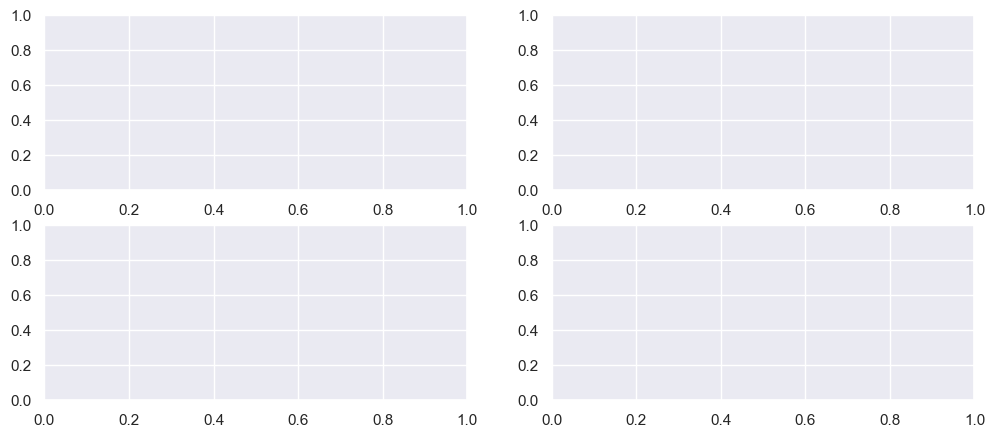

In [7]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12, 5))
ax = [a for a_list in ax for a in a_list]
dims = [10, 11, 12, 13]
for i, d in enumerate(dims):
    ax[i].plot(np.arange(1, 17), pe[:16, d], color="C%i" % i, marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title("Кодирование в скрытом измерении %d" % (d + 1))
    ax[i].set_xlabel("Расположение в последовательности", fontsize=10)
    ax[i].set_ylabel("Позиционное кодирование", fontsize=10)
    ax[i].set_xticks(np.arange(1, 17))
    ax[i].tick_params(axis="both", which="major", labelsize=10)
    ax[i].tick_params(axis="both", which="minor", labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

## FPN



<center>     
    <img src="./img/fpn.png" alt="Изображения двухмерные" style="width: 400px;"/>
    <strong>111</strong>
</center>

Сеть с пирамидой признаков, или Feature Pyramid Network (FPN), — это с нейронная сеть с особым механизмом извлечения извлечения признаков, которое принимает одномасштабное изображение произвольного размера в качестве входных данных и выводит карты признаков пропорционального размера на нескольких заданных уровнях.

Этот процесс не зависит от базовых архитектур. Таким образом, он действует как универсальное решение для построения пирамид признаков внутри глубоких сверточных сетей, которые будут использоваться в различных задачах.

Feature Pyramid является одним из главных базовых механизмов многокомпонентных систем распознавания (обычно в CV) для обнаружения объектов в различных масштабах.


Подробнее можете ознакомиться в статье и на сайте-сборнике SOTA решений:

https://paperswithcode.com/method/fpn

https://paperswithcode.com/methods/category/feature-pyramid-blocks

(a) Функциональная пирамида изображений
Она широко используется в эпоху создания ручных признаков.

(b) Одномерная карта признаков
Это стандартное решение ConvNet на одном входном изображении, где предсказание происходит в конце сети.

(c) Пирамидальная иерархия признаков
На каждом уровне делается предсказание, подобно SSD. Она повторно использует многомасштабные карты признаков с разных уровней, вычисленные на прямом проходе, и поэтому обходится бесплатно. Однако она упускает возможность повторного использования карт признаков более высокого разрешения в иерархии, следовательно, пропускает обнаружение маленьких объектов.

(d) Сеть пирамид признаков
Она объединяет низкоразрешенные, семантически насыщенные признаки с высокоразрешенными, семантически слабыми признаками через верхний и боковой путь. Эта пирамида признаков имеет богатую семантику на всех уровнях и быстро создается из одного входного изображения, сохраняя при этом мощность представления, скорость и память. Некоторые параллельные работы, такие как DSSD, также используют этот подход.

(e) Похожая архитектура
Некоторые недавние исследования приняли похожие верхние и обходные соединения, такие как TDM, SharpMask, RED-Net, U-Net, которые были довольно популярны в тот момент, но делают предсказание только на последнем этапе.

---
# Спасибо за внимание!

---
### Технический раздел:

<br/> next <em class="qs"></em> qs line 
<br/> next <em class="an"></em> an line 
<br/> next <em class="nt"></em> an line 
<br/> next <em class="df"></em> df line 
<br/> next <em class="ex"></em> ex line 
<br/> next <em class="pl"></em> pl line 
<br/> next <em class="mn"></em> mn line 
<br/> next <em class="plmn"></em> plmn line 
<br/> next <em class="hn"></em> hn line 

----

-----

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# загружаем данные MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# превращаем каждую картинку в двумерный массив
batch_size, img_rows, img_cols = 64, 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [4]:
# приводим данные к типу float32 и нормализуем их от 0 до 1
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [5]:
# переводим правильные ответы в one-hot представление
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [6]:
# инициализируем модель
model = Sequential()

# добавляем сверточные слои
model.add(Convolution2D(32, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))
model.add(Convolution2D(64, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# добавляем полносвязные слои
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
# компилируем и запускаем обучение
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

# выводим результаты
print("Test score: %f" % score[0])
print("Test accuracy: %f" % score[1])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


C:\ProgramData\Anaconda3\lib\site-packages\keras-2.0.2-py3.6.egg\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 26s - loss: 0.1243 - acc: 0.9619 - val_loss: 0.0376 - val_acc: 0.9877
Epoch 2/10
60000/60000 [==============================] - 14s - loss: 0.0420 - acc: 0.9870 - val_loss: 0.0298 - val_acc: 0.9909
Epoch 3/10
60000/60000 [==============================] - 14s - loss: 0.0302 - acc: 0.9902 - val_loss: 0.0251 - val_acc: 0.9915
Epoch 4/10
60000/60000 [==============================] - 13s - loss: 0.0224 - acc: 0.9931 - val_loss: 0.0218 - val_acc: 0.9928
Epoch 5/10
60000/60000 [==============================] - 14s - loss: 0.0185 - acc: 0.9941 - val_loss: 0.0253 - val_acc: 0.9926
Epoch 6/10
60000/60000 [==============================] - 13s - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0251 - val_acc: 0.9922
Epoch 7/10
60000/60000 [==============================] - 14s - loss: 0.0138 - acc: 0.9957 - val_loss: 0.0248 - val_acc: 0.9933
Epoch 8/10
60000/60000 [==============================

---

In [9]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras import models

(28, 28, 1) (28, 28)


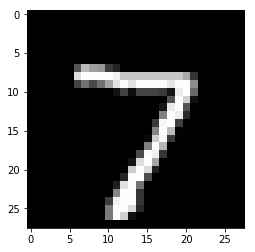

In [10]:
viz_fig = X_test[0] 
pixels = viz_fig.reshape((28, 28))
print(viz_fig.shape, pixels.shape)
plt.imshow(pixels, cmap='gray')
plt.show()

In [11]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [13]:
# Extracts the outputs of the top 4 layers:
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [14]:
viz_fig_v = viz_fig.copy()
viz_fig_v = np.expand_dims(viz_fig_v, axis=0)
viz_fig_v = viz_fig_v.astype("float32")
viz_fig_v /= 255

viz_fig_v.shape, input_shape

((1, 28, 28, 1), (28, 28, 1))

In [15]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(viz_fig_v)

In [19]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


0


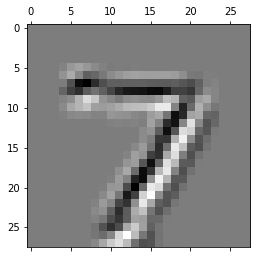

1


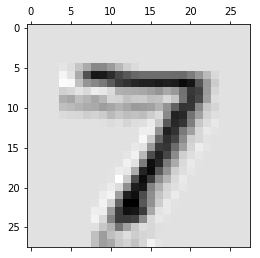

2


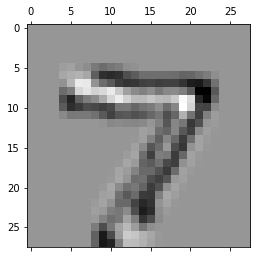

3


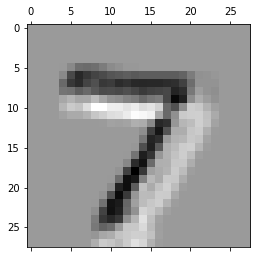

4


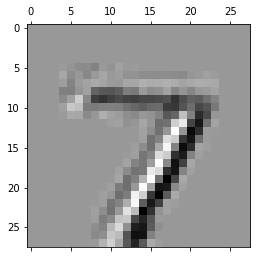

5


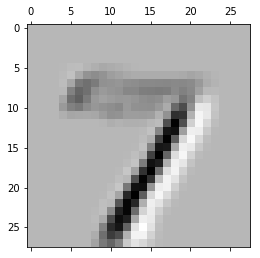

6


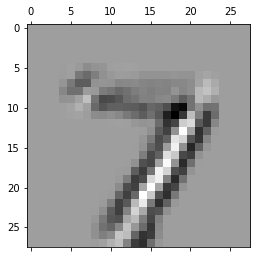

7


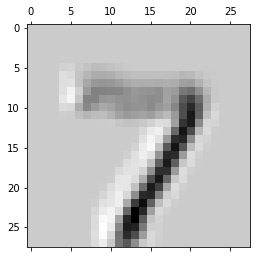

8


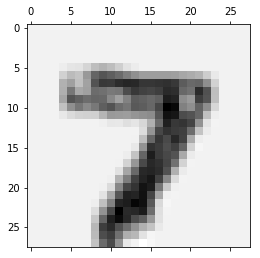

9


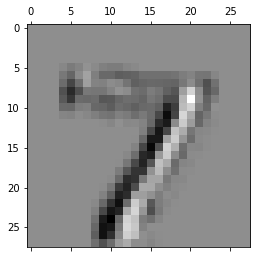

10


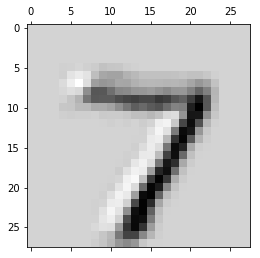

11


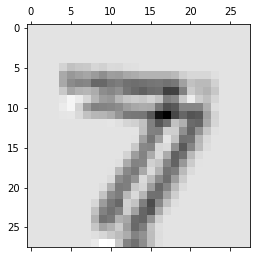

12


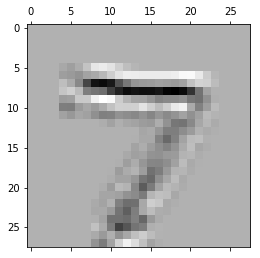

13


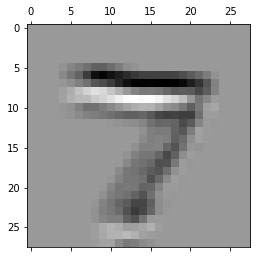

14


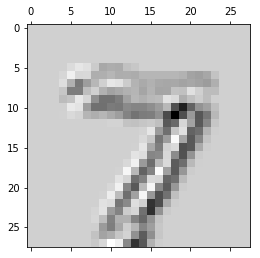

15


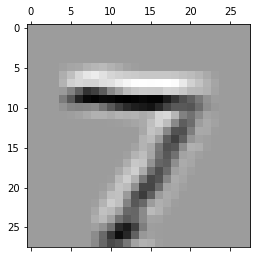

16


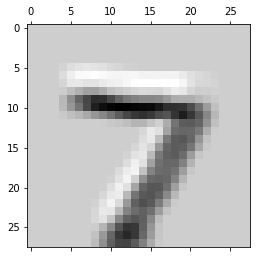

17


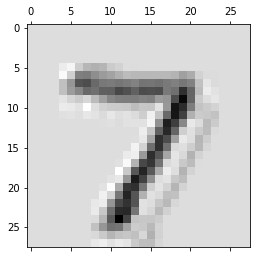

18


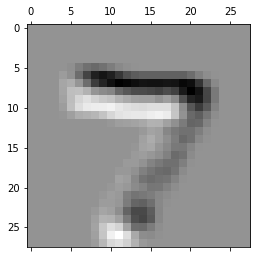

19


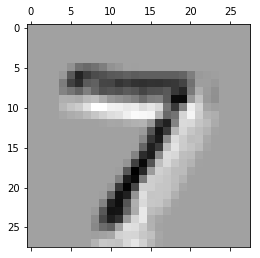

20


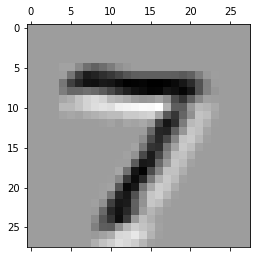

21


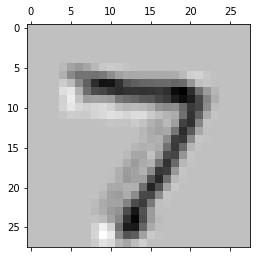

22


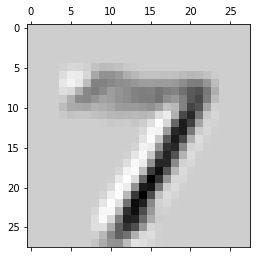

23


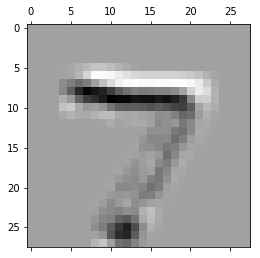

24


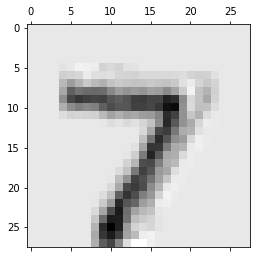

25


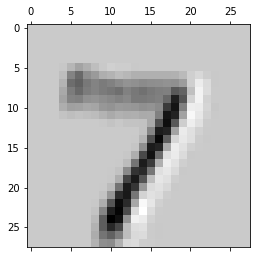

26


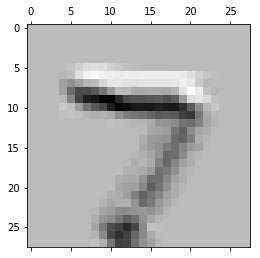

27


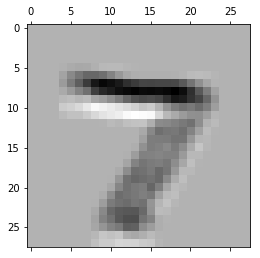

28


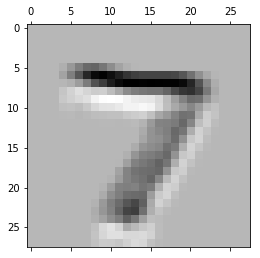

29


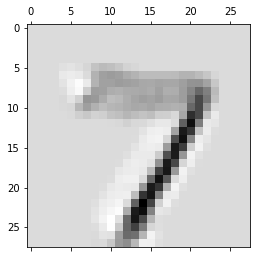

30


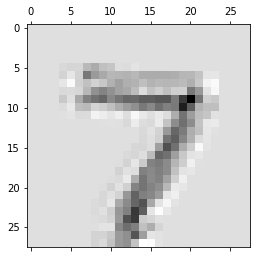

31


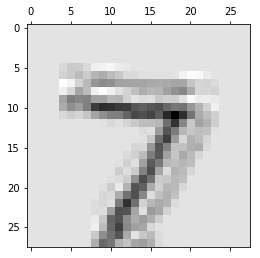

In [20]:
for i in range(32):
    print(i)
    plt.matshow(first_layer_activation[0, :, :, i], cmap='gray')
    plt.show()

In [16]:
second_layer_activation = activations[3]
print(second_layer_activation.shape)

(1, 14, 14, 64)


0


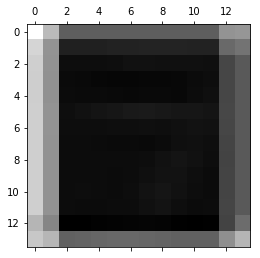

1


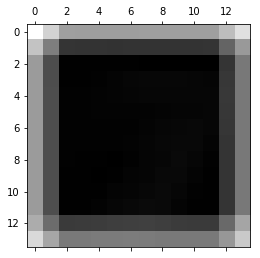

2


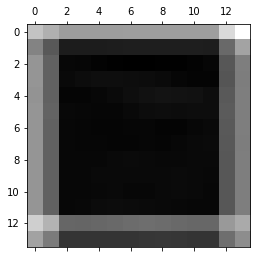

3


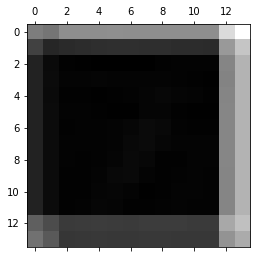

4


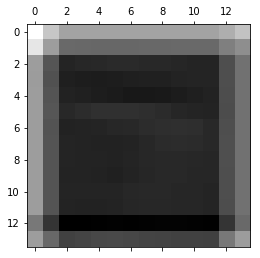

5


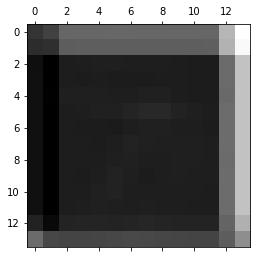

6


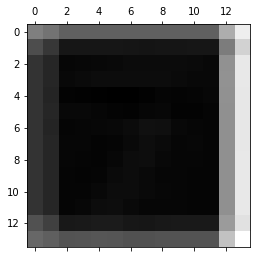

7


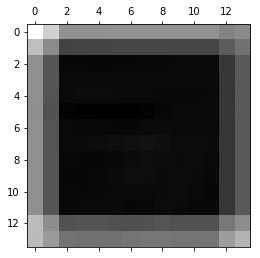

8


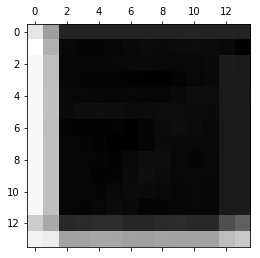

9


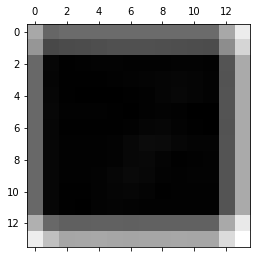

10


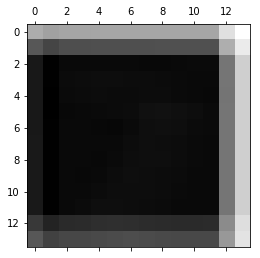

11


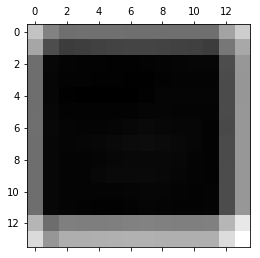

12


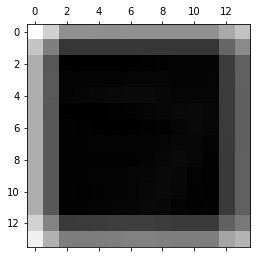

13


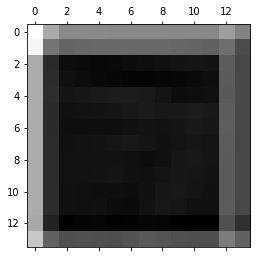

14


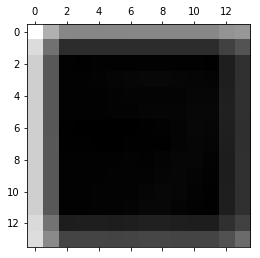

15


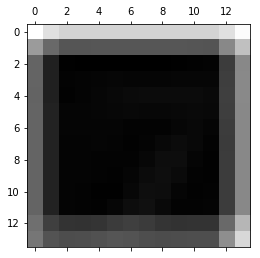

16


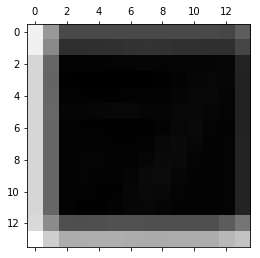

17


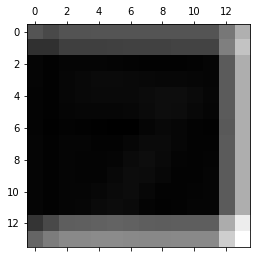

18


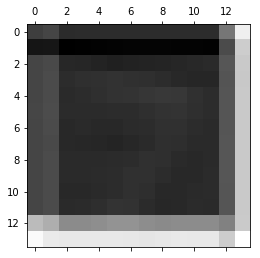

19


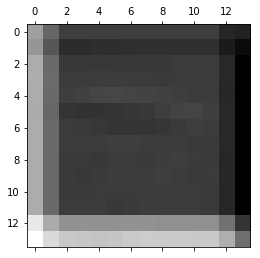

20


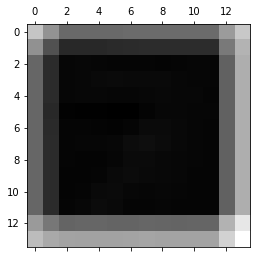

21


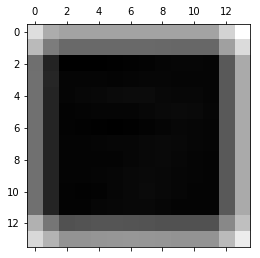

22


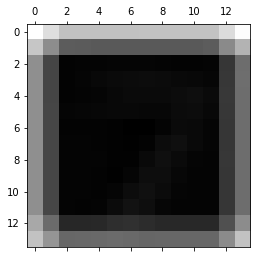

23


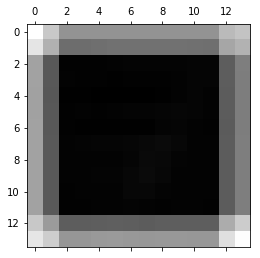

24


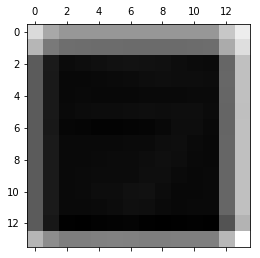

25


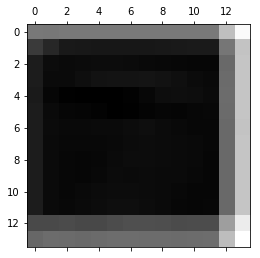

26


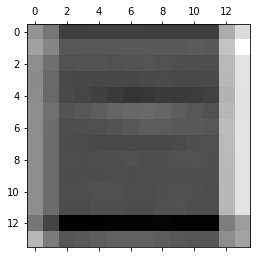

27


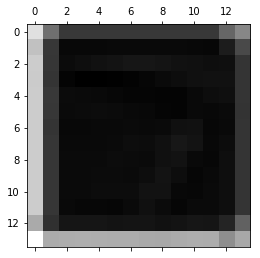

28


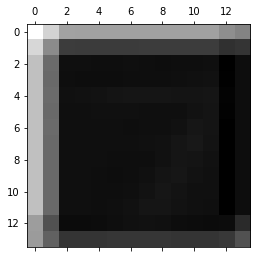

29


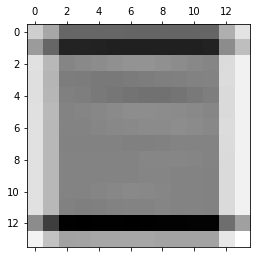

30


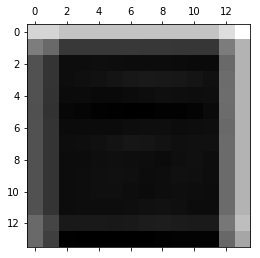

31


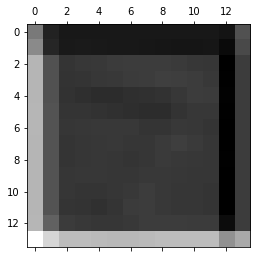

32


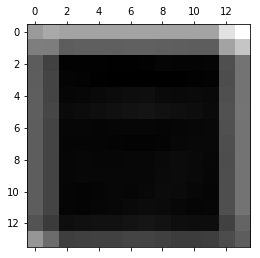

33


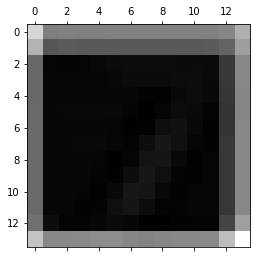

34


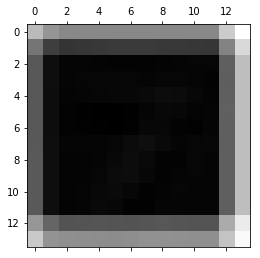

35


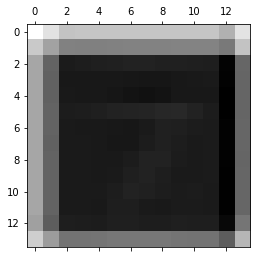

36


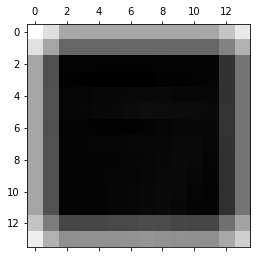

37


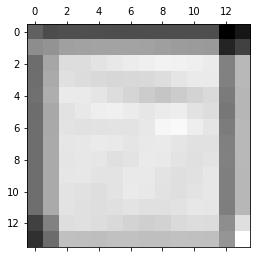

38


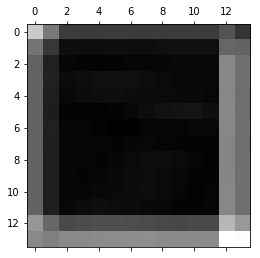

39


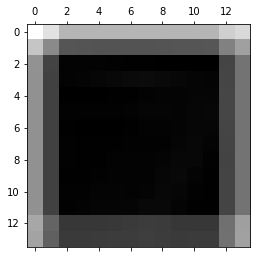

40


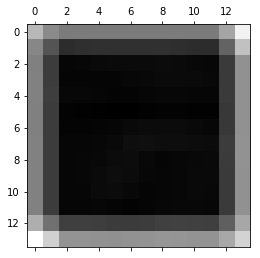

41


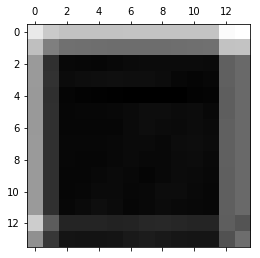

42


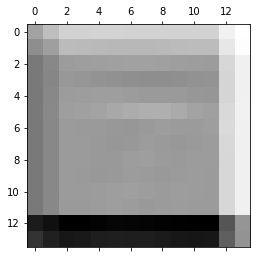

43


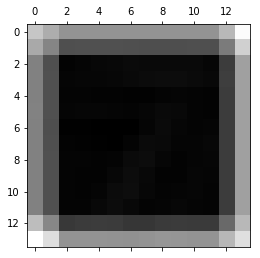

44


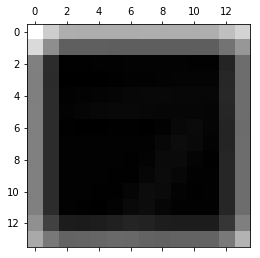

45


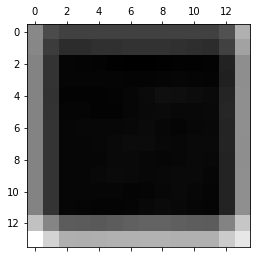

46


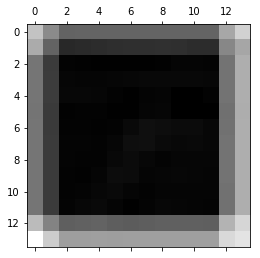

47


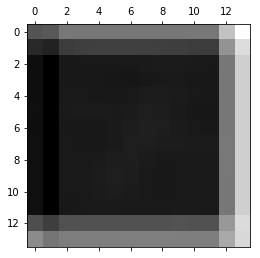

48


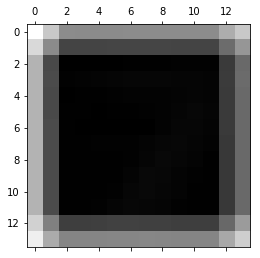

49


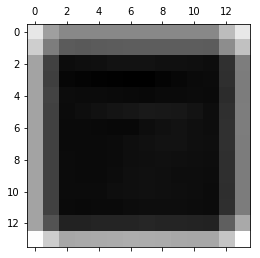

50


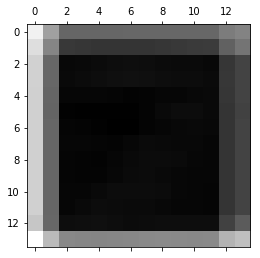

51


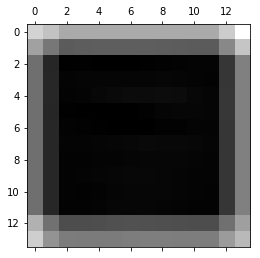

52


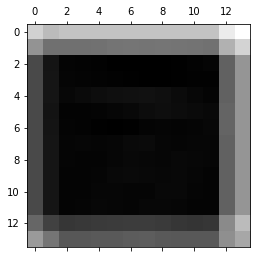

53


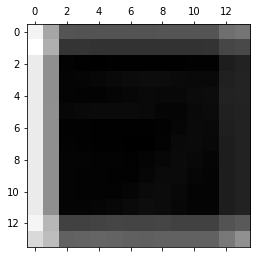

54


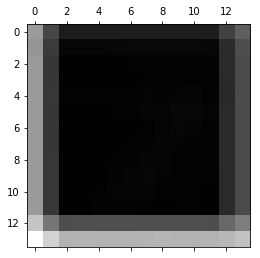

55


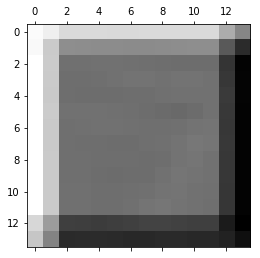

56


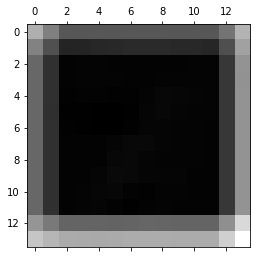

57


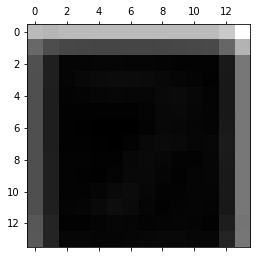

58


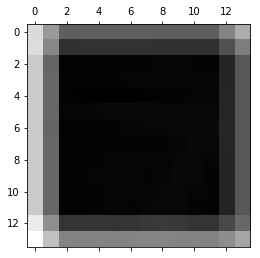

59


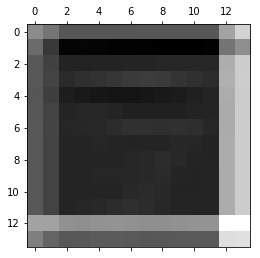

60


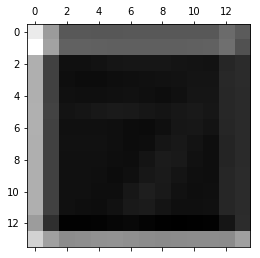

61


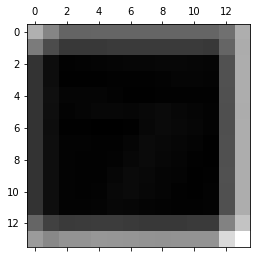

62


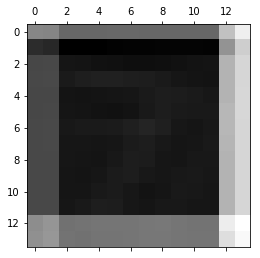

63


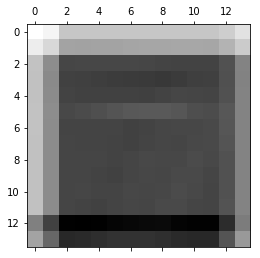

In [17]:
for i in range(64):
    print(i)
    plt.matshow(second_layer_activation[0, :, :, i], cmap='gray')
    plt.show()